In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


scaled_disorder = 1

base_dir = "../results/"

print(base_dir[2:])

/Users/rafal.swietek/Projects/CODES/QHamSolver/QSunU1/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
/results/


In [3]:
L_total=15

J=1
alfa=1.0
h=1.0
w=0.5
zeta=0.2
N=3
gamma=1.0
ini_ave=1
L = L_total - N
Sz=0
scaled_disorder = 1

alfa_vals = np.arange(0.6, 0.999, 0.01)
print(alfa_vals)

sizes = np.arange(10, 19, 2)


for nu in [500, 0.1, 0.25, 0.5, 1.0]:
    frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

    folder_base = f'./collected data/'
    folder = folder_base + base_dir[3:] + f"nu={nu}/"
    os.makedirs(folder_base, exist_ok=True)
    os.makedirs(folder, exist_ok=True)

    for L_total in sizes:
        sub_sizes = np.arange(0, L_total+1)
        L = L_total - N
        name_out = folder + "_L=%g,N=%g,J=%g,gamma=%g"%(L, N, J, gamma) + (",ini_ave.hdf5" if ini_ave else ".hdf5")
        
        entropy         = np.zeros((sub_sizes.size, alfa_vals.size));  entropy     .fill(np.nan)
        entropy_site    = np.zeros((sub_sizes.size, alfa_vals.size));  entropy_site.fill(np.nan)
        gap_ratio       = np.zeros((alfa_vals.size));                  gap_ratio   .fill(np.nan)
        realisations    = np.zeros((alfa_vals.size));                  realisations.fill(np.nan)
        Sinfo_vN        = np.zeros((alfa_vals.size));                  Sinfo_vN.fill(np.nan)
        for ii, alfa in enumerate(alfa_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, Sz=Sz, ini_ave=ini_ave, ext='.hdf5')
            # if not exists(name): 
            #     name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5', scaled_disorder=scaled_disorder)
            #print(name)
            exist_S_vn = 1
            if exists(name):
                with h5py.File(name, "r") as file:
                        energies = np.array(file.get('mean energies'))
                        ratio = np.array(file.get('gap ratio'))
                        realis = np.array(file.get('realisations'))[0]
                        realisations[ii] = realis
                        if J != 1.0:
                            Sinfo = np.array(file.get('von Neumann participation entropy'))
                        
                        
                        dim = energies.size
                        num = frac(dim)
                        # print(dim, num)
                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if num == dim or my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2)
                        if num == dim or my_max >= dim: my_max = dim-1

                        # try:
                            # if num == 500:          gap_ratio[ii] = np.array(file.get('gap ratio 500'))
                            # elif num == dim//2:     gap_ratio[ii] = np.array(file.get('gap ratio D/2'))
                            # else:
                                # print("otherwise")
                        gap_ratio[ii] = np.mean(ratio[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(ratio)
                        if J != 1.0:
                            Sinfo_vN[ii] = np.mean(Sinfo[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Sinfo)

                        for ii_LA in range(sub_sizes.size):
                            S = np.array(file.get('entropies'))[ii_LA]
                            Ssite = np.array(file.get('single_site_entropy'))[ii_LA]
                            entropy[ii_LA][ii]         = np.mean(S[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(S)
                            entropy_site[ii_LA][ii]    = np.mean(Ssite[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Ssite)
                        # except TypeError:
                        #     print(ratio)
            else:
                print(name)

        if not np.all( np.isnan(realisations) ):
            print("SAVED:", name_out)
            # print(LA, entropy[LA])
            hf = h5py.File(name_out, 'w')
            hf.create_dataset('interaction',            alfa_vals.shape,        data = alfa_vals)
            hf.create_dataset('gap_ratio',              gap_ratio.shape,        data = gap_ratio)
            hf.create_dataset('entropy',                entropy.shape,          data = entropy)
            hf.create_dataset('single_site_entropy',    entropy_site.shape,     data = entropy_site)
            hf.create_dataset('realisations',           realisations.shape,     data = realisations)
            hf.create_dataset('vN info entropy',        Sinfo_vN.shape,         data = Sinfo_vN)
            hf.close()

[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
SAVED: ./collected data/results/nu=500/_L=7,N=3,J=1,gamma=1,ini_ave.hdf5
SAVED: ./collected data/results/nu=500/_L=9,N=3,J=1,gamma=1,ini_ave.hdf5
SAVED: ./collected data/results/nu=500/_L=11,N=3,J=1,gamma=1,ini_ave.hdf5
SAVED: ./collected data/results/nu=500/_L=13,N=3,J=1,gamma=1,ini_ave.hdf5
../results/Entropy/Eigenstate/_L=15,N=3,J=1,g=1,zeta=0.2,alfa=0.6,h=1,w=0.5,Sz=0,ini_ave.hdf5
../results/Entropy/Eigenstate/_L=15,N=3,J=1,g=1,zeta=0.2,alfa=0.61,h=1,w=0.5,Sz=0,ini_ave.hdf5
../results/Entropy/Eigenstate/_L=15,N=3,J=1,g=1,zeta=0.2,alfa=0.62,h=1,w=0.5,Sz=0,ini_ave.hdf5
../results/Entropy/Eigenstate/_L=15,N=3,J=1,g=1,zeta=0.2,alfa=0.63,h=1,w=0.5,Sz=0,ini_ave.hdf5
../results/Entropy/Eigenstate/_L=15,N=3,J=1,g=1,zeta=0.2,alfa=0.65,h=1,w=0.5,Sz=0,ini_ave.hdf5
../results/Entropy/Eigenstat

[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


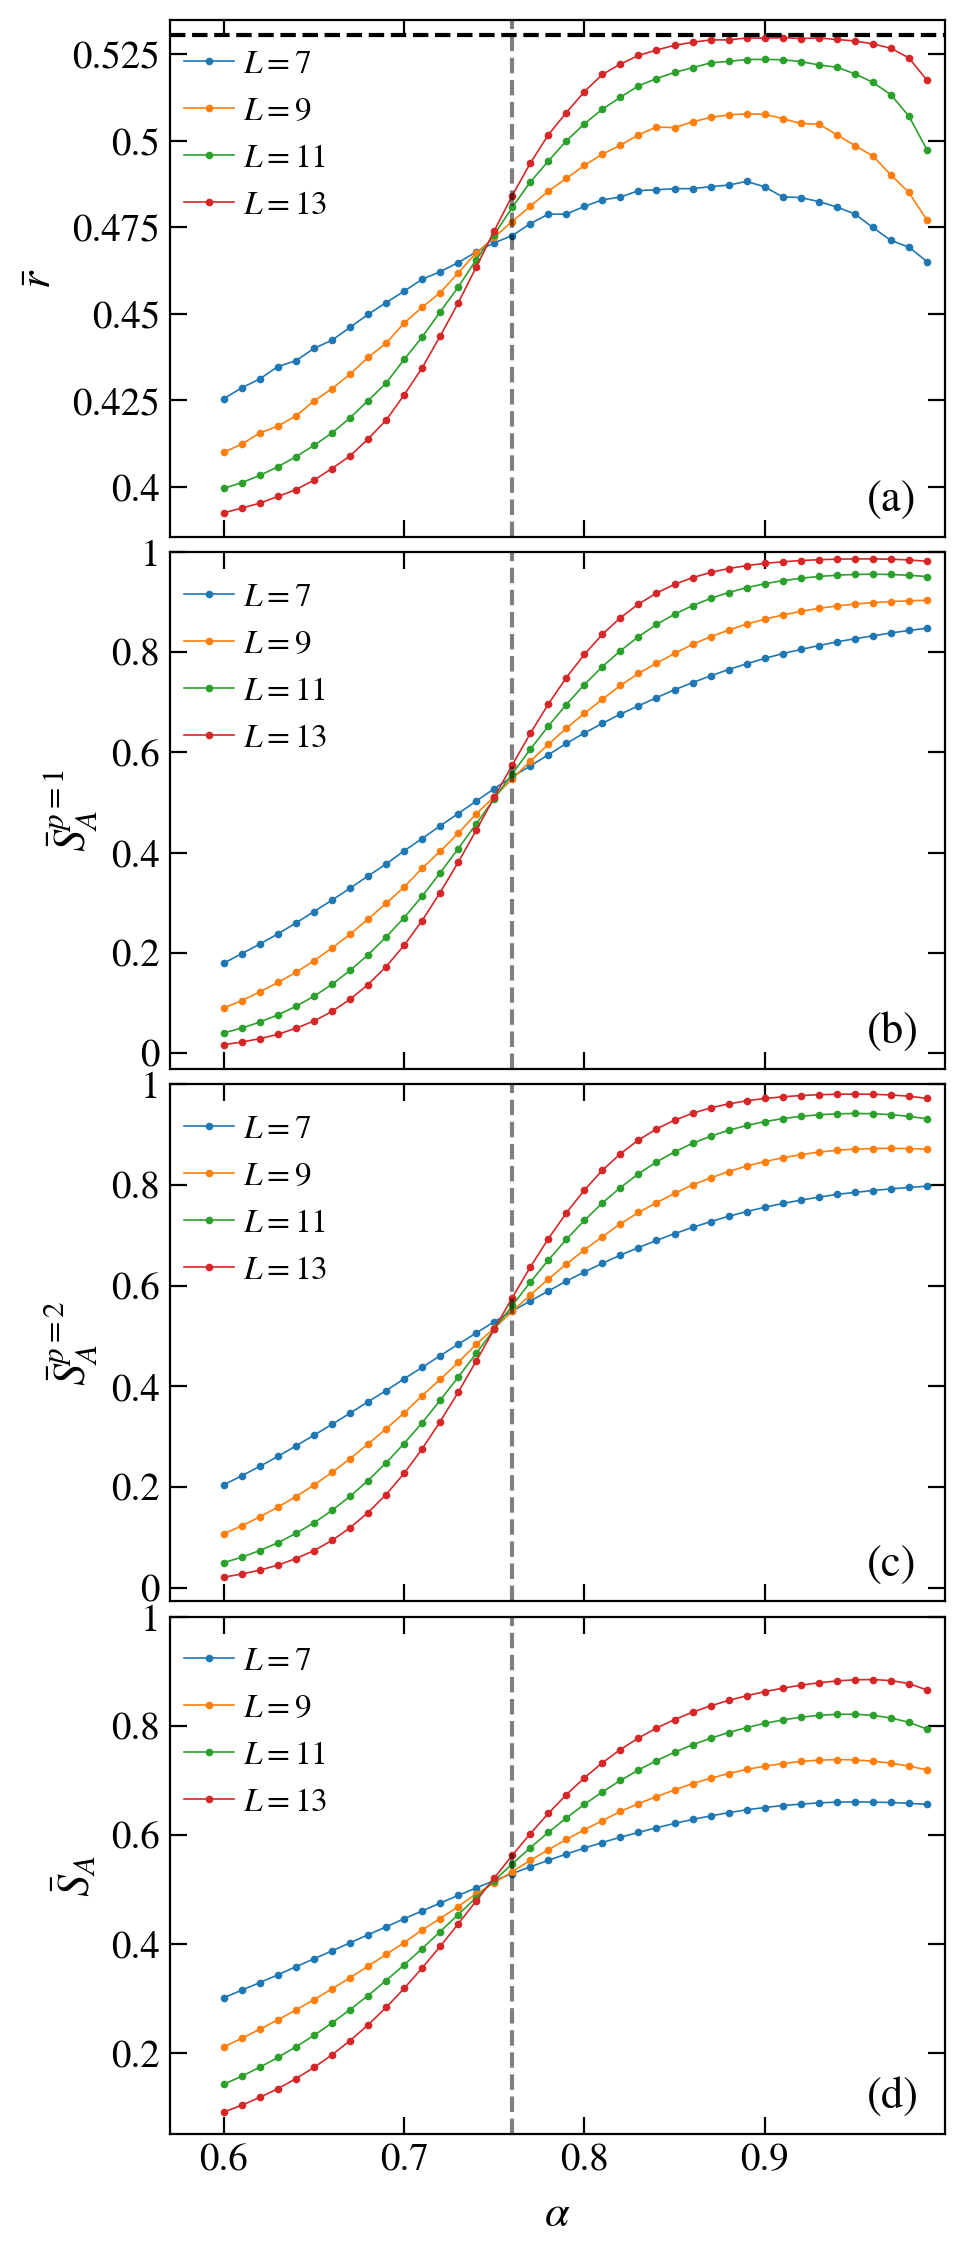

In [9]:
L_total=15
J=1.0
alfa=1.0
h=1.0
w=0.5
zeta=0.2
N=3
gamma=1.0
ini_ave=1
L = L_total - N

alfa_vals = np.arange(0.6, 0.999, 0.01)
print(alfa_vals)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=4, ncols=1, figsize=(5,14), dpi = 200, sharex=True)

sizes = np.arange(10, 17, 2)

rescale = 0

p = 2

nu = 0.1
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)
    
xlab = r"$\alpha$"
ylab = r"$\bar{r}$"

ps = [0, 1, 2, -1]
for idx1, p in enumerate(ps):
    
    interaction = []
    ydata = []
    for L_total in sizes:
        sub_sizes = np.arange(0, L_total+1)
        L = L_total - N
        LA = L_total - p if p > 0 else L_total // 2
        name_out = folder + "_L=%g,N=%g,J=%g,gamma=%g"%(L, N, J, gamma) + (",ini_ave.hdf5" if ini_ave else ".hdf5")

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                alfa_vals    = np.array(file.get('interaction'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
                interaction.append(alfa_vals)
                # ydata.append(gap_ratio if idx1 == 0 else entropy[LA] / page(LA, L_total - LA))
                entr = entropy[LA] / page(LA, L_total - LA)
                ydata.append(gap_ratio if idx1 == 0 else entr)
        else:
            print(name_out)
  
    for ii, L in enumerate(sizes - N):
        axis[idx1].plot(interaction[ii], ydata[ii], marker='o', markersize=1.75, lw=0.6, label=r"$L=%d$"%L)
        # axis[idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, par, *crit_pars), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

    axis[idx1].set_xlim(0.95*min(np.array(interaction).flatten()), 1.01*max(np.array(interaction).flatten()))

    # axis[idx1].axvline(x=0.7, ls='--', c='k', alpha=0.5)
    axis[idx1].axvline(x=0.76, ls='--', c='k', alpha=0.5)
    # axis[idx1].axvline(x=0.85, ls=':', c='k', alpha=0.5)
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$\bar{S}_A^{p=%d}$"%p if p > 0 else r"$\bar{S}_A$", xlabel=xlab, font_size=14, set_legend=False)
    fig_help.set_legend(axis[idx1], loc = 'upper left', fontsize=12, anchor=(-0.02, 1))
# axis[0].axhline(y=0.3863, ls='--', color='black')
axis[0].set_ylim(None, 0.535)
axis[0].axhline(y=0.5307, ls='--', color='black')

axis[1].set_ylim(None, 1)
axis[2].set_ylim(None, 1)
axis[3].set_ylim(None, 1)

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel="", font_size=14, set_legend=False)
fig_help.set_legend(axis[0], loc = 'upper left', fontsize=12, anchor=(-0.02, 1))

for aa in [axis]:
    for ax in np.array(aa).flatten():
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis[0].annotate(r"(a)", fontsize=16, xy=(0.9, 0.05), xycoords='axes fraction')
axis[1].annotate(r"(b)", fontsize=16, xy=(0.9, 0.05), xycoords='axes fraction')
axis[2].annotate(r"(c)", fontsize=16, xy=(0.9, 0.05), xycoords='axes fraction')
axis[3].annotate(r"(d)", fontsize=16, xy=(0.9, 0.05), xycoords='axes fraction')
# axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)

fig.subplots_adjust(wspace = 0.2, hspace=0.03)
plt.savefig("plots/Fig_entropy.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig_entropy.png", bbox_inches = 'tight', pad_inches=0.02)